In [367]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft


from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [368]:
# This sets up the figure size
plt.rcParams['figure.figsize'] = [6, 6]

In [369]:
#Load and clean data
data = pd.read_csv('AMZN.csv')
data = data[['Date', 'Close']]



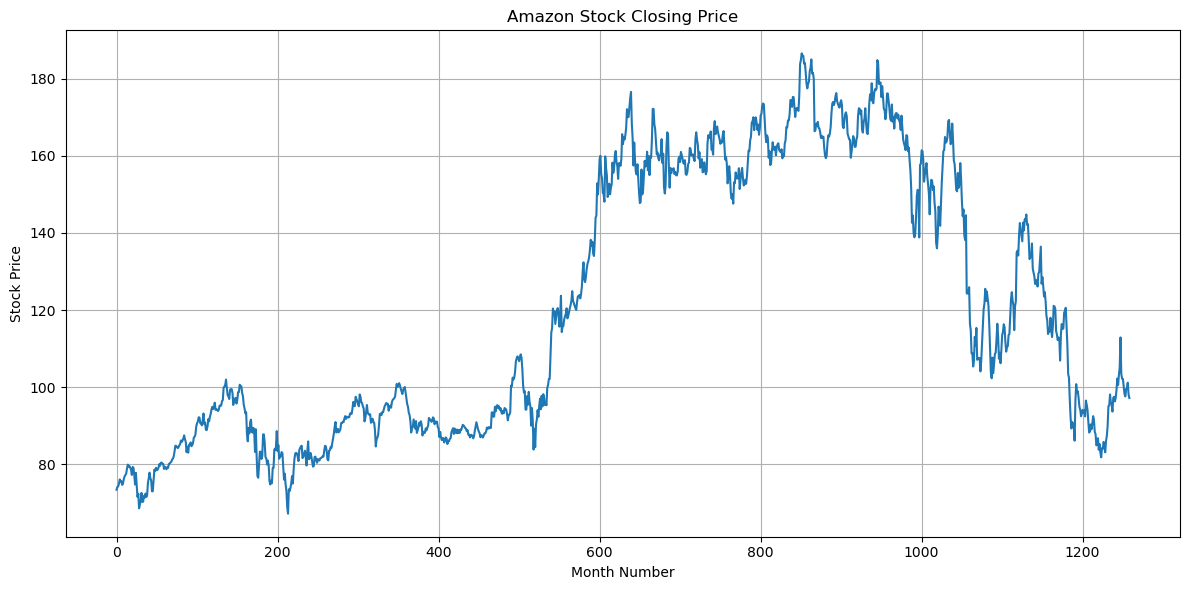

In [370]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'])
plt.title('Amazon Stock Closing Price')
plt.xlabel('Month Number')
plt.ylabel('Stock Price')
plt.grid(True)
plt.tight_layout()
plt.show()

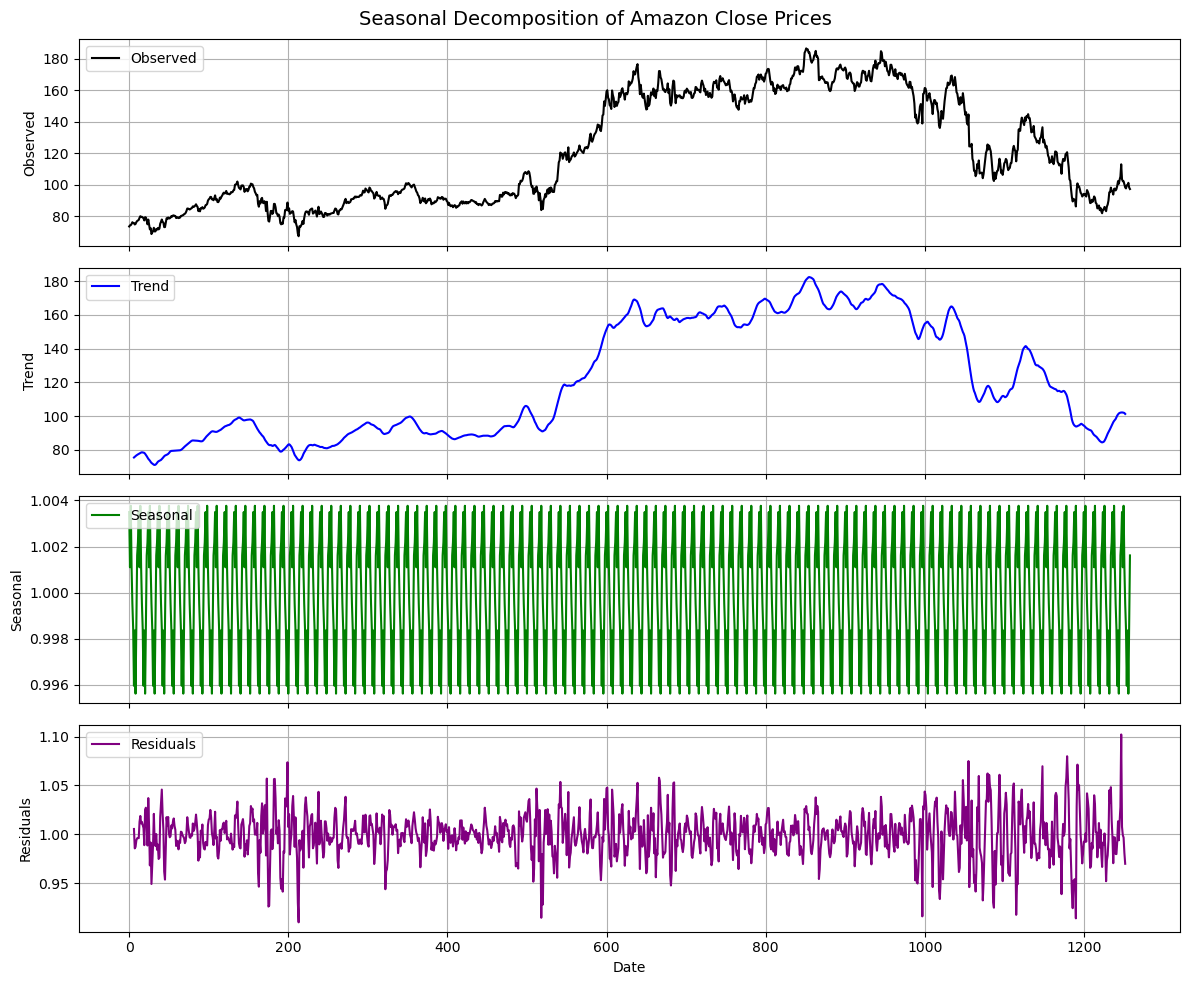

In [371]:

# Perform seasonal decomposition
result_amazon = seasonal_decompose(data['Close'], model='multiplicative', period=12)

# Plot full seasonal decomposition with residuals as a line plot
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Observed
axes[0].plot(result_amazon.observed, label='Observed', color='black')
axes[0].set_ylabel('Observed')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Trend
axes[1].plot(result_amazon.trend, label='Trend', color='blue')
axes[1].set_ylabel('Trend')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Seasonal
axes[2].plot(result_amazon.seasonal, label='Seasonal', color='green')
axes[2].set_ylabel('Seasonal')
axes[2].legend(loc='upper left')
axes[2].grid(True)

# Residuals 
axes[3].plot(result_amazon.resid, label='Residuals', color='purple')
axes[3].set_ylabel('Residuals')
axes[3].legend(loc='upper left')
axes[3].grid(True)

# Final formatting
fig.suptitle('Seasonal Decomposition of Amazon Close Prices', fontsize=14)
plt.xlabel('Date')
plt.tight_layout()
plt.show()


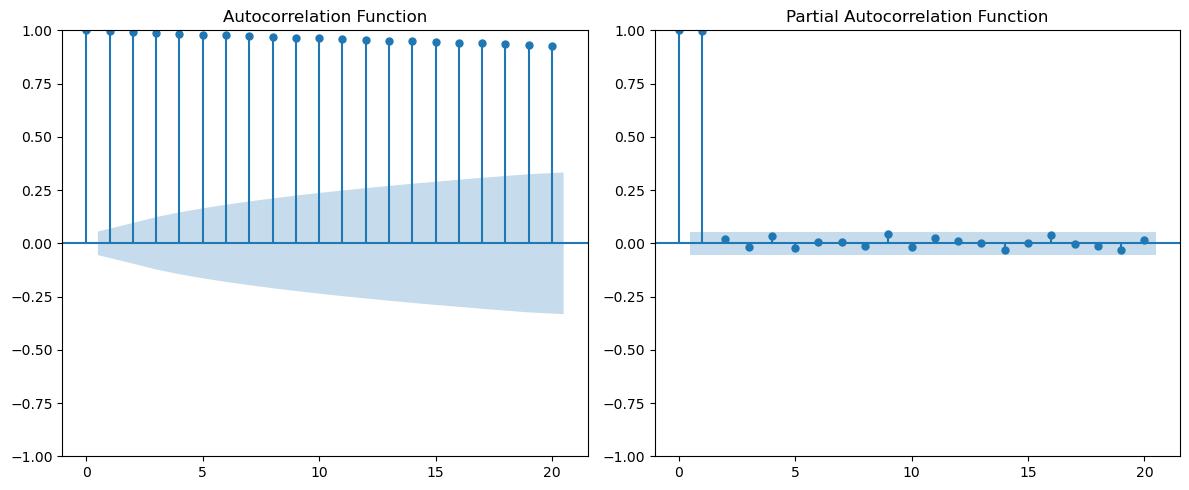

In [372]:
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(data['Close'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(data['Close'], ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [373]:
# Perform ADF test
result = adfuller(data['Close'])

# Print results
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])


ADF Test Statistic: -1.657808991333171
p-value: 0.4529710546516684


In [374]:

# First differencing
data['Close_diff'] = data['Close'].diff()
data.dropna(inplace=True)
data.head(10)

,Date,Close,Close_diff
1,2018-02-21,74.146004,0.728501
2,2018-02-22,74.266998,0.120994
3,2018-02-23,75.000000,0.733002
4,2018-02-26,76.097504,1.097504
5,2018-02-27,75.598999,-0.498505
6,2018-02-28,75.622498,0.023499
7,2018-03-01,74.672501,-0.949997
8,2018-03-02,75.012497,0.339996
9,2018-03-05,76.180496,1.167999
10,2018-03-06,76.882004,0.701508


In [375]:
# ADF Test on differenced series
adf_result = adfuller(data['Close_diff'])

print("ADF Test (on first-differenced Close prices):")
print(f"ADF Statistic : {adf_result[0]}")
print(f"p-value       : {adf_result[1]}")


ADF Test (on first-differenced Close prices):
ADF Statistic : -36.25077933242773
p-value       : 0.0


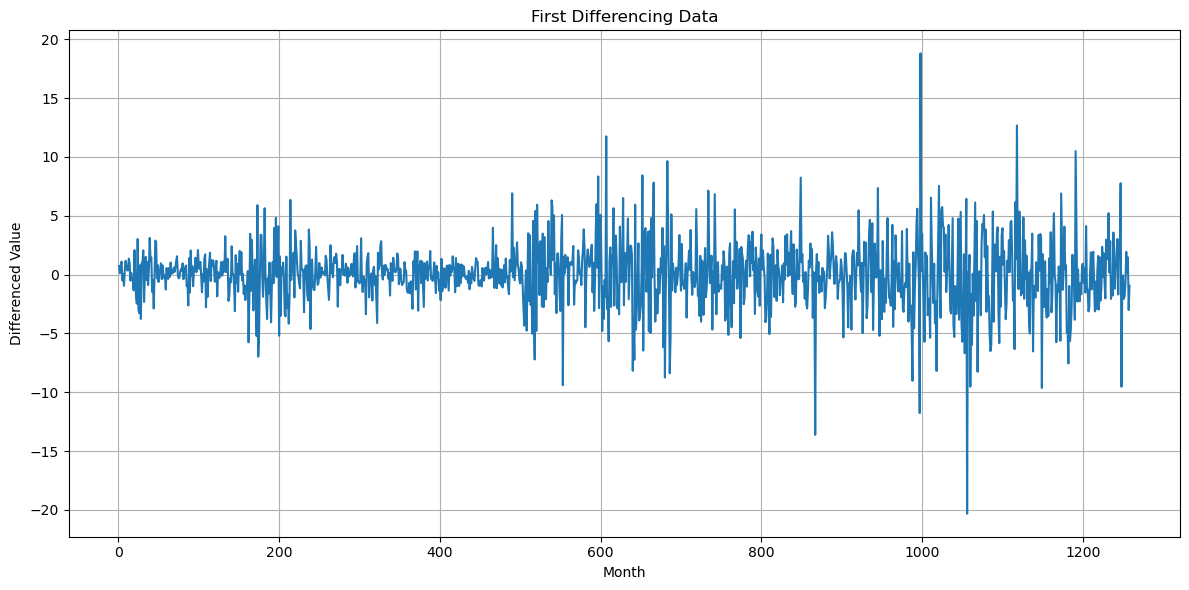

In [376]:
# Plot the differenced log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(data['Close_diff'])
plt.title('First Differencing Data')
plt.xlabel('Month')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.tight_layout()
plt.show()

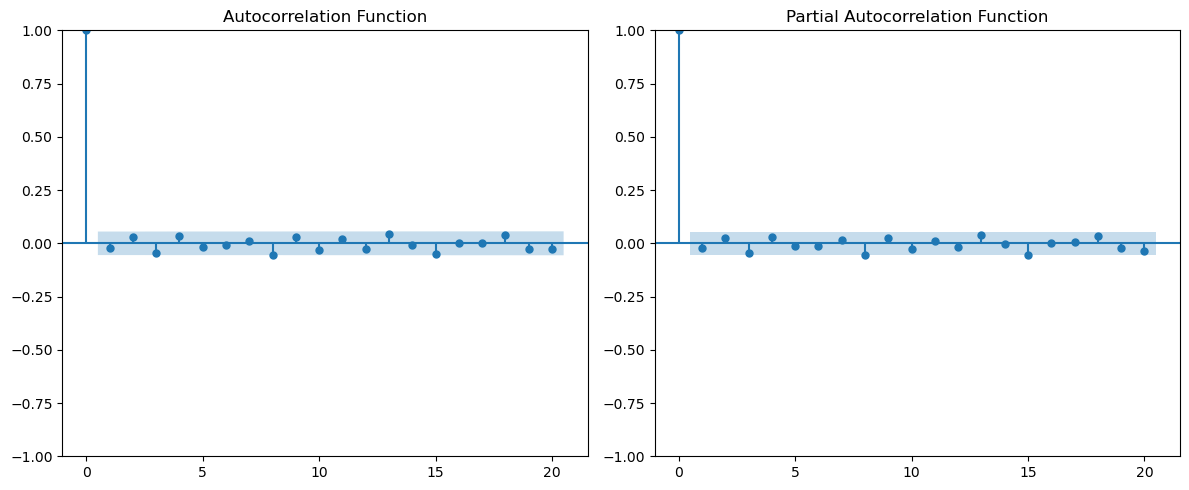

In [377]:
# Drop NA values
series = data['Close_diff'].dropna()
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(series, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(series, ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [378]:
from tqdm.notebook import tqdm
import pandas as pd
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

def optimize_ARIMA(endog, order_list):
    """
    Return dataframe with parameters and corresponding AIC
    
    order_list - list with (p, d, q) tuples
    endog - the observed variable, e.g., data['Close']
    """
    
    results = []
    
    for order in tqdm(order_list):  # tqdm_notebook can be flaky, tqdm is safer
        try: 
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
            aic = model_fit.aic
            results.append([order, aic])
        except Exception as e:
            # Optional: print or log error details
            print(f"Failed to fit ARIMA{order}: {e}")
            continue
            
    if not results:
        print("No ARIMA models were successfully fitted.")
        return pd.DataFrame(columns=['(p, d, q)', 'AIC'])
    
    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [379]:



ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

    
# print out the first few rows of order_list to check it looks right
order_list[:10]



[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [380]:
# call opitimize_ARIMA

result_df = optimize_ARIMA(data['Close'], order_list)


# print out the ordered list. The best model fit (lowest AIC) will be shown at the top
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(2, 1, 2)",6118.418968
1,"(3, 1, 2)",6120.143937
2,"(2, 1, 3)",6120.148541
3,"(3, 1, 3)",6121.488767
4,"(4, 1, 2)",6122.056430
...,...,...
59,"(7, 1, 3)",6134.293588
60,"(0, 1, 7)",6134.427323
61,"(4, 1, 7)",6134.600455
62,"(7, 1, 0)",6134.640642


In [381]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


from pmdarima.model_selection import train_test_split
train, test = train_test_split(data['Close'], train_size=82)

model = pm.auto_arima(train, seasonal=False, m=1, test='adf',max_p=6, max_q=6)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -136.190
Date:                Fri, 11 Apr 2025   AIC                            274.379
Time:                        18:17:19   BIC                            276.774
Sample:                             0   HQIC                           275.340
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.6902      0.217      7.801      0.000       1.266       2.115
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 9.43
Prob(Q):                              0.89   Pr

In [382]:
from statsmodels.tsa.arima.model import ARIMA

# p,d,q ARIMA Model
best_model = ARIMA(data['Close'], order=(2,1,2))

best_model_fit = best_model.fit()

In [383]:
#summary of the model
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1258
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3054.209
Date:                Fri, 11 Apr 2025   AIC                           6118.419
Time:                        18:17:19   BIC                           6144.101
Sample:                             0   HQIC                          6128.071
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6947      0.015   -112.038      0.000      -1.724      -1.665
ar.L2         -0.9605      0.015    -64.843      0.000      -0.990      -0.931
ma.L1          1.6973      0.011    152.574      0.0

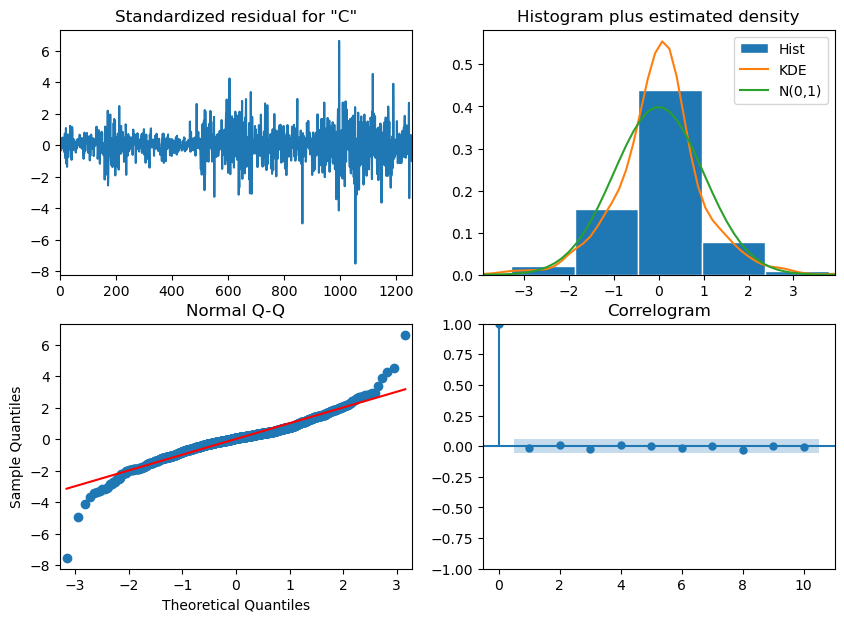

In [384]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [385]:
#get prediction start and end dates
test_data = data['Close']

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

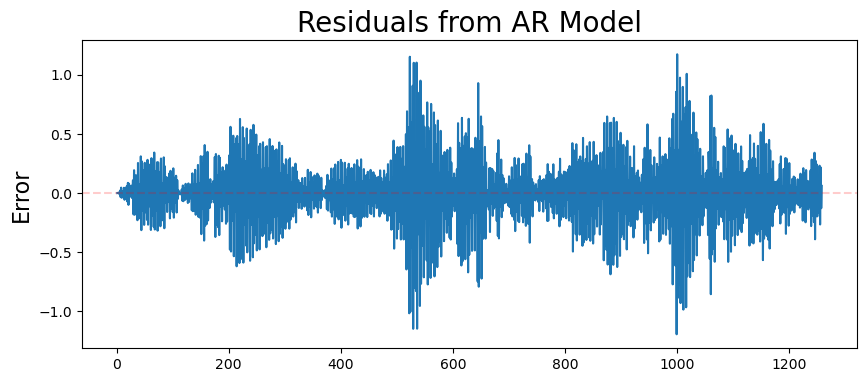

In [386]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

In [387]:
# Assess the root mean square of the residuals

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.3122558814769519


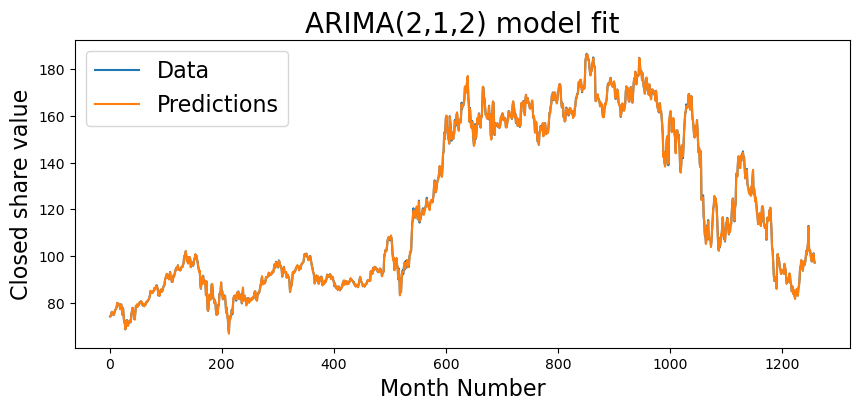

In [388]:
# Plot the model prediction against the data

plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('ARIMA(2,1,2) model fit', fontsize=20)
plt.ylabel('Closed share value', fontsize=16)
plt.xlabel('Month Number', fontsize=16)
plt.show()

In [389]:
def forecast_accuracy(forecast, actual):
    
    forecast = np.array(forecast)
    actual = np.array(actual)

    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # Correlation

    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)           # MinMax

    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'corr': corr,
        'minmax': minmax
    }


In [390]:
metrics = forecast_accuracy(predictions, test_data)
print(metrics)


{'mape': 0.002071685107453862, 'me': 7.690482846956213e-05, 'mae': 0.23994823601833468, 'mpe': 2.459446170158717e-06, 'rmse': 0.3122558814769519, 'corr': 0.9999595850079883, 'minmax': 0.0020679769071662024}


In [391]:


# make the predictions for 24 steps ahead
predictions_int = best_model_fit.get_forecast(steps=504)
predictions_int.predicted_mean

1258    97.138808
1259    97.100132
1260    97.224450
1261    97.050919
1262    97.225589
          ...    
1757    97.144310
1758    97.144304
1759    97.144307
1760    97.144308
1761    97.144303
Name: predicted_mean, Length: 504, dtype: float64

In [392]:
# get a better view
predictions_int.conf_int()

,lower Close,upper Close
1258,91.754255,102.523361
1259,89.475365,104.724899
1260,87.839029,106.609870
1261,86.255837,107.846002
1262,85.111093,109.340086
...,...,...
1757,-23.940082,218.228703
1758,-24.061114,218.349721
1759,-24.182015,218.470630
1760,-24.302799,218.591415


In [393]:
# add the predicted mean column in

conf_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

conf_df.head()

,predicted_mean,lower Close,upper Close
1258,97.138808,91.754255,102.523361
1259,97.100132,89.475365,104.724899
1260,97.224450,87.839029,106.609870
1261,97.050919,86.255837,107.846002
1262,97.225589,85.111093,109.340086


In [394]:
# change the name of the column heads

conf_df = conf_df.rename(columns={'predicted_mean': 'Predictions', 'lower Close': 'Lower CI', 'upper Close': 'Upper CI'})
conf_df.head()

,Predictions,Lower CI,Upper CI
1258,97.138808,91.754255,102.523361
1259,97.100132,89.475365,104.724899
1260,97.224450,87.839029,106.609870
1261,97.050919,86.255837,107.846002
1262,97.225589,85.111093,109.340086


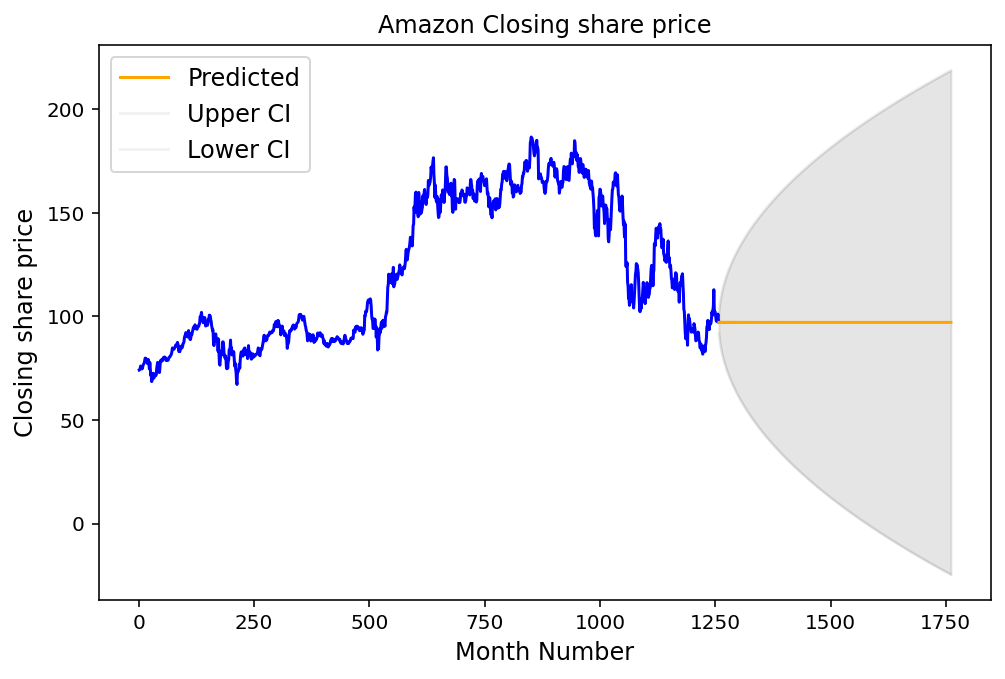

In [395]:


fig, ax = plt.subplots(figsize = (8,5), dpi=144)
ax.plot(data['Close'], 'b')

ax.set(title='Amazon Closing share price')


x = conf_df.index.values


upper = conf_df['Upper CI']
lower = conf_df['Lower CI']


conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI', alpha=0.1)
lower.plot(color = 'grey', label = 'Lower CI', alpha=0.1)

# fill between the conf intervals
ax.fill_between(x, lower, upper, color='grey', alpha=0.2)

plt.ylabel('Closing share price', fontsize=12)
plt.xlabel('Month Number', fontsize=12)

plt.legend(loc = 'upper left', fontsize = 12)

plt.savefig("")
plt.show()

In [396]:


# Load Amazon dataset
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
close_prices = df[['Close']].copy()



In [397]:
# Normalize with MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

In [398]:
# Create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


In [399]:
# Train-test split
train_size = int(len(X) * 0.9)
X_train, y_train = X[:train_size], y[:train_size]


In [400]:
# Model
model = Sequential([
    LSTM(100, return_sequences=True, activation='relu', input_shape=(time_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Recursive Forecasting
future_steps = 504  # ≈ 24 months

last_sequence = scaled_data[-time_steps:].reshape(1, time_steps, 1)
future_preds_scaled = []

for _ in range(future_steps):
    pred = model.predict(last_sequence)[0][0]
    future_preds_scaled.append(pred)
    
    new_input = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)
    last_sequence = new_input

# Inverse transform
future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

# Build forecast index
last_date = close_prices.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='B')[1:]

# Build forecast DataFrame
forecast_df = pd.DataFrame(future_preds, index=future_dates, columns=['Forecasted'])

# Combine for plotting
combined = pd.concat([close_prices, forecast_df], axis=1)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1576
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0045
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0017
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0017
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0015
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0014
Epoc

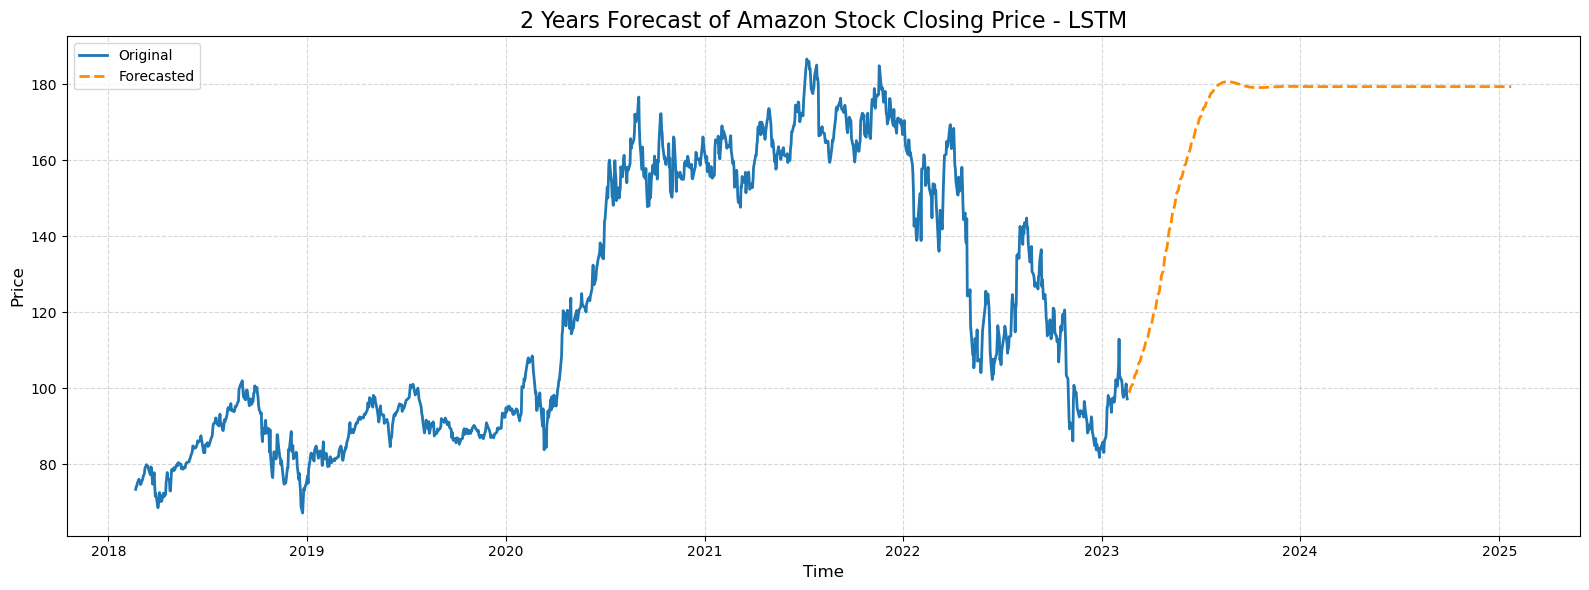

In [401]:
# Plot
plt.figure(figsize=(16, 6))
plt.plot(combined['Close'], label='Original', linewidth=2)
plt.plot(combined['Forecasted'], label='Forecasted', linestyle='--', color='darkorange', linewidth=2)
plt.title('2 Years Forecast of Amazon Stock Closing Price - LSTM', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("lstmamz.png", dpi =300)
plt.show()


In [402]:


# Load Amazon stock data
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
close_array = df['Close'].values

# Apply FFT
X = fft(close_array)




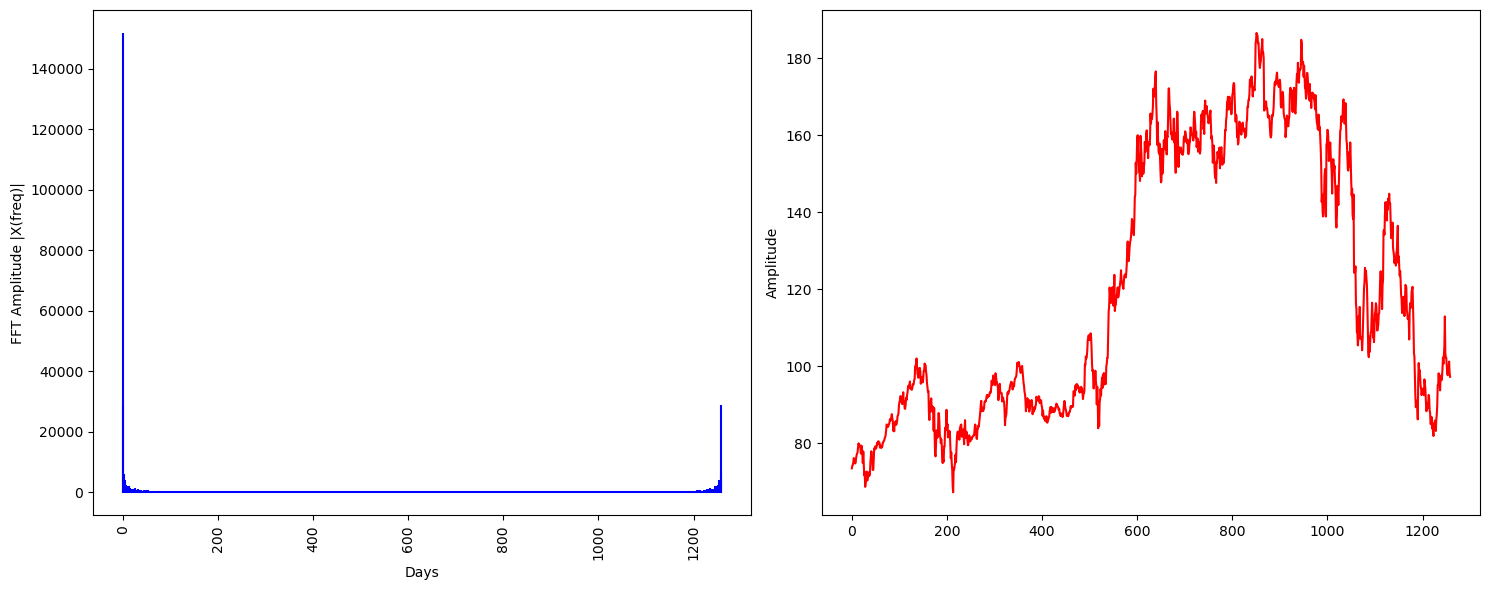

In [403]:
# Plot the results (FFT spectrum + IFFT reconstruction)
plt.figure(figsize=(15, 6))

# Subplot 1: FFT Amplitude Spectrum (Stem Plot)
plt.subplot(121)
plt.stem(np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xticks(rotation=90)
plt.xlabel('Days')
plt.ylabel('FFT Amplitude |X(freq)|')

# Subplot 2: Reconstructed Signal from IFFT
plt.subplot(122)
plt.plot(ifft(X).real, 'r')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()